# A Brief Machine Learning Tutorial in python 
As some of you wanted more practical examples of machine learning algorithms, I created this brief tutorial to showcase some of the notions studied in class. The code is mostly based on Sebastian Raschka's book "Python Machine Learning". There is an abundance of resources online or in books that you can refer to for other problems/algorithms. The best way to master coding ML models is to get your hands dirty and code things yourself. Equipped with the theoretical knowledge you gained in class, you should be capable of at least attempting some competitions on kaggle for example. 

In this tutorial we'll be highlighting the importance of cross-validation and why you should use it to tune your models. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Set-up 
What is the use of machine learning models? In most cases we have this scenario: you have some data and you want to learn something from that data. After gaining that knowledge, you want to be able to use that knowledge to work on data that you haven't seen yet. This exercise usually have the following steps: 
* Data preprocessing: transform your data into a form that is optimal for the use of learning algorithms
* Learning: training and selecting a learning model. This step relies heavily on your experience and knowledge of ML concepts. If you have a classification problem, you'll need to select a classification model. May be some insights from data preprocessing could help you pick the best model. But you'll usually need to try implementing few models before landing on one model. 
* Evaluation: In this step, you'll need to evaluate and compare the model(s) that you picked previously. Your choice shouldn't be based only on the training set but also on the testing and validation sets. That way you ensure that your model will generalize well on unseen data. 
* Prediction or generalization: This is the step where you can use your model for unseen data. 

Let's try to put these steps into practice. In this tutorial we will be using the Wisconsin breast cancer data set. This is the first time I'll be using this dataset so I want to know more about it. 

In [2]:
# Generate a dataset 
from sklearn import datasets
ds = datasets.load_breast_cancer(return_X_y = False)
print(ds.DESCR)
X = ds.data
y = ds.target

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

## Data preprocessing
From the description above, it looks like my data might use some transformations. The first thing that I notice in the summary statistics table is that my variables have different ranges. Some between ~140 to ~2500 and others are between ~0.05 and ~0.1. A good practice would be standardize this data. Furthermore, I have 30 attributes in this data. That's a large number of attributes! I could go and calculate the correlations between these attributes and manually pick the ones I think are the most important. Or I could use a useful dimensionality reduction technique: Principal Component Analysis. I do not intend to implement PCA myself nor intensively analyse it, all I want is reduce my attributes from 30 to 3 (a number of my choice, you could try experimenting with another one). 


## Learning/Model selection
The breast cancer problem is a classification problem. I haven't visualized my data yet (and I don't intend to do it since I can't decide which attributes to pick or even if my choice of 3 in PCA is good or not), hence I will be training a couple of models before making my decision. These models are decision trees, support vector machines and Fischer linear classifiers (LDA). My choice might be random, you can probably come up with better choices but that's fine. I am learning myself :)  

### Pipelines
Any kind of transformations we use before training the data needs to be reused for prediction. A useful tool in scikit-learn is the Pipeline which includes all the transformations steps we use and apply them on the new data. 

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

#NOTE: I didn't specify any parameters for the DT and LDA, you should try that yourselves (google is your best friend)

pipe_svm = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components=3)), ('clf', SVC(C=0.01, kernel='sigmoid'))])
pipe_lda = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components=3)), ('clf', LinearDiscriminantAnalysis())])
pipe_dt = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components=3)), ('clf', DecisionTreeClassifier())])

## Almost there
Now that I have my pieplines ready to test, I can split my data into training and testing. Remember that you always need different sets for your learning model. A model trained, tested and validated on the same dataset is useless!

In [4]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Learning -1-
Now that I will train my different models and see what results they give me. 

In [5]:
# Train SVM 
pipe_svm.fit(X_train, y_train)
print('Test SVM Accuracy: %.3f' %pipe_svm.score(X_test, y_test))

# Train LDA
pipe_lda.fit(X_train, y_train)
print('Test LDA Accuracy: %.3f' %pipe_lda.score(X_test, y_test))

# Train DT
pipe_dt.fit(X_train, y_train)
print('Test DT Accuracy: %.3f' %pipe_dt.score(X_test, y_test))

Test SVM Accuracy: 0.901
Test LDA Accuracy: 0.930
Test DT Accuracy: 0.918


## Learning -2-
It looks from the results above that LDA and DT should be my top choices. For the purpose of this tutorial, I'll continue working on the SVM. You are highly encouraged to play around with the other models. 

My next step should be to 1)make sure that my model will work well on unseen data and 2)that I picked the best model possible (aka I selected the optimal hyperparameters for my model). This is where cross-validation becomes handy. 


## Cross-validation
 Cross-validation helps us estimate the model's generalization error and tune the model hyperparameters. Please check the lecture notes for a good explanation of this method and its benefits. 

In [6]:
from sklearn.cross_validation import StratifiedKFold
kfold = StratifiedKFold(y=y_train, n_folds=10, random_state=1)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_svm.fit(X_train[train], y_train[train])
    score = pipe_svm.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Accuracy: %.3f' %(k+1, np.bincount(y_train[train]), score))
    
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [134 224], Accuracy: 0.900
Fold: 2, Class dist.: [134 224], Accuracy: 0.950
Fold: 3, Class dist.: [134 224], Accuracy: 0.900
Fold: 4, Class dist.: [134 224], Accuracy: 0.925
Fold: 5, Class dist.: [134 224], Accuracy: 0.950
Fold: 6, Class dist.: [134 224], Accuracy: 0.925
Fold: 7, Class dist.: [134 224], Accuracy: 0.925
Fold: 8, Class dist.: [134 224], Accuracy: 0.950
Fold: 9, Class dist.: [134 224], Accuracy: 0.950
Fold: 10, Class dist.: [135 225], Accuracy: 0.974
CV accuracy: 0.935 +/- 0.023


## Evaluation
It looks like my SVM is not a bad choice eventually. To further improve my model, I will be using the learning curves and validation curves to investigate if my model has some overfitting(high variance) or underfitting(high bias) issues. 
Models that re too complex (with many degrees of freedom or parameters) tend to overfit the training data and do not generalize to unseen data. Since data can be expensive in real life, plotting the training and validation accuracies is a good exercise to address this problem. 

/anaconda2/lib/python2.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


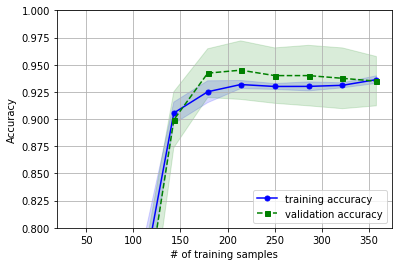

In [7]:
from sklearn.learning_curve import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_svm, X=X_train, y=y_train, train_sizes = np.linspace(.1, 1.0, 10), cv = 10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis =1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis =1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=.15, color='green')

plt.grid()
plt.xlabel('# of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([.8, 1.0])
plt.show()

I am not super happy with the way my model performs (I actually set it up to be bad for demonstration purposes). As you might have noted above, I made some choices of parameters that might not be the best (C=0.01, kernel='sigmoid').Choosing the kernel for an SVM depends on prior knowledge of the data. If such a knowledge doesn't exist then using RBF is a good choice (that's actually the default choice in sklearn). But also the penalty parameter C I set doesn't seem like a very educated guess. C controls how much we're penalizing a misclassification. A small C would cause the model to have large-margin separating plans while a large one would do the opposite. I cannot decide which value I should be using, nor which kernel would work best for me (although I can guess based on the lecture notes). Therefore, my next step should be experimenting with these parameters using the validation curves. Validation curves are similar to learning curves with the different that the accuracy is a function of the model parameters (C in this case) instead of the training size. Let's see what it looks like. 

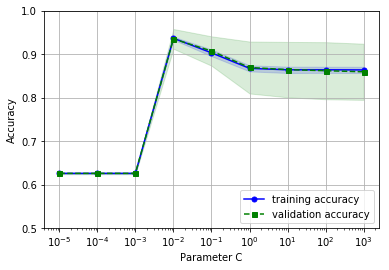

In [8]:
from sklearn.learning_curve import validation_curve 
param_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
train_scores, test_scores = validation_curve(estimator=pipe_svm, X=X_train, y=y_train, param_name='clf__C', param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=.15, color='green')
plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([.5, 1.0])
plt.show()

From the graph above, it looks like the best C should be around 0.01 and 0.1. I could use another hyperparameters optimization technique called grid search. Basically it is a brute-force search of the hypothesis space based on a list of different hyperparameters

In [11]:
from sklearn.grid_search import GridSearchCV
param_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.1]
pipe_gs = pipe_svm = Pipeline([('scl', StandardScaler()), ('clf', SVC())])
param_grid = [{'clf__C': param_range,
               'clf__kernel': ['linear']},
               {'clf__C': param_range, 
               'clf__gamma': param_range, 
               'clf__kernel': ['poly']}]
gs = GridSearchCV(estimator=pipe_gs, param_grid=param_grid, scoring='accuracy', cv=10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.982412060302
{'clf__C': 0.1, 'clf__kernel': 'linear'}


## Conclusion
From the result above, the parameters I should be using are 0.1 for C and linear for the kernel which isn't a very surprising choice. Now I have enough confidence in my model to use it on unseen data. Now it is your turn to play with the DT and LDA models :) 